In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterstats
import rioxarray
import xarray as xr
from helpers.utils import kelvin_to_celcius
from rasterio.crs import CRS

In [14]:
us_states_counties_filepath = "./data/gadm41_USA_2.json"
gdf_us_states_counties = gpd.read_file(filename=us_states_counties_filepath)
gdf_us_states_counties.head(10)


,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,USA.1.1_1,USA,UnitedStates,USA.1_1,Alabama,NA,Autauga,NA,NA,County,County,NA,US.AL.AU,"MULTIPOLYGON (((-86.91670 32.66430, -86.82680 ..."
1,USA.1.2_1,USA,UnitedStates,USA.1_1,Alabama,NA,Baldwin,NA,NA,County,County,NA,US.AL.BD,"MULTIPOLYGON (((-87.74420 30.29440, -87.74030 ..."
2,USA.1.3_1,USA,UnitedStates,USA.1_1,Alabama,NA,Barbour,NA,NA,County,County,NA,US.AL.BR,"MULTIPOLYGON (((-85.41610 31.61960, -85.49130 ..."
3,USA.1.4_1,USA,UnitedStates,USA.1_1,Alabama,NA,Bibb,NA,NA,County,County,NA,US.AL.BI,"MULTIPOLYGON (((-87.42080 32.87450, -87.42030 ..."
4,USA.1.5_1,USA,UnitedStates,USA.1_1,Alabama,NA,Blount,NA,NA,County,County,NA,US.AL.BU,"MULTIPOLYGON (((-86.96290 33.85860, -86.96510 ..."
5,USA.1.6_1,USA,UnitedStates,USA.1_1,Alabama,NA,Bullock,NA,NA,County,County,NA,US.AL.BL,"MULTIPOLYGON (((-85.41000 32.14680, -85.40960 ..."
6,USA.1.7_1,USA,UnitedStates,USA.1_1,Alabama,NA,Butler,NA,NA,County,County,NA,US.AL.BT,"MULTIPOLYGON (((-86.70190 31.52520, -86.83880 ..."
7,USA.1.8_1,USA,UnitedStates,USA.1_1,Alabama,NA,Calhoun,NA,NA,County,County,NA,US.AL.CN,"MULTIPOLYGON (((-85.73850 33.96880, -85.52930 ..."
8,USA.1.9_1,USA,UnitedStates,USA.1_1,Alabama,NA,Chambers,NA,NA,County,County,NA,US.AL.CM,"MULTIPOLYGON (((-85.13910 32.74630, -85.28510 ..."
9,USA.1.10_1,USA,UnitedStates,USA.1_1,Alabama,NA,Cherokee,NA,NA,County,County,NA,US.AL.CH,"MULTIPOLYGON (((-85.53010 33.94180, -85.52930 ..."


In [15]:
# get BBOX bounds from geospatial Dataframe
xmin, ymin, xmax, ymax = gdf_us_states_counties.total_bounds
xmin, ymin, xmax, ymax


(-179.1506, 18.9099, 179.7734, 72.687)

In [16]:
cds_dataset_filepath = './data/adaptor.mars.internal-1680421125.4570282-18286-4-a773a2ce-80f1-4909-979d-6f2e094a8092.nc'
cds_dataset = xr.open_dataset(filename_or_obj=cds_dataset_filepath)
cds_dataset

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 744)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-02 07:39:05 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [17]:
latitiude = cds_dataset['latitude'].values
longitude = cds_dataset['longitude'].values
t2m = cds_dataset['t2m'].isel(time=0).values

In [18]:
affine = rio.open(cds_dataset_filepath).transform
affine

Affine(0.25, 0.0, -180.125,
       0.0, -0.25, 90.125)

In [19]:
raster_ds_values = np.apply_along_axis(kelvin_to_celcius, axis=1, arr=cds_dataset['t2m'].isel(time=0).values)
raster_ds_values

array([[-24.709564, -24.709564, -24.709564, ..., -24.709564, -24.709564,
        -24.709564],
       [-25.254364, -25.254364, -25.252747, ..., -25.25763 , -25.25763 ,
        -25.254364],
       [-25.521072, -25.521072, -25.519455, ..., -25.524323, -25.524323,
        -25.522705],
       ...,
       [-23.015   , -23.013382, -23.0085  , ..., -23.023132, -23.021515,
        -23.016632],
       [-22.455566, -22.453949, -22.453949, ..., -22.46045 , -22.458817,
        -22.458817],
       [-22.401901, -22.401901, -22.401901, ..., -22.401901, -22.401901,
        -22.401901]], dtype=float32)

In [35]:
zonal_stats = rasterstats.zonal_stats(gdf_us_states_counties['geometry'], raster_ds_values, affine=affine)
len(zonal_stats)

3148

In [24]:
gdf_us_states_counties['zs_mean'] = [zs['mean'] for zs in zonal_stats]
gdf_us_states_counties['zs_mean']

0       23.496140
1       23.423503
2       23.699417
3       22.856201
4       20.571304
          ...    
3143   -10.979262
3144   -13.154315
3145    -9.509293
3146   -14.737811
3147   -14.800205
Name: zs_mean, Length: 3148, dtype: float64

<Axes: >

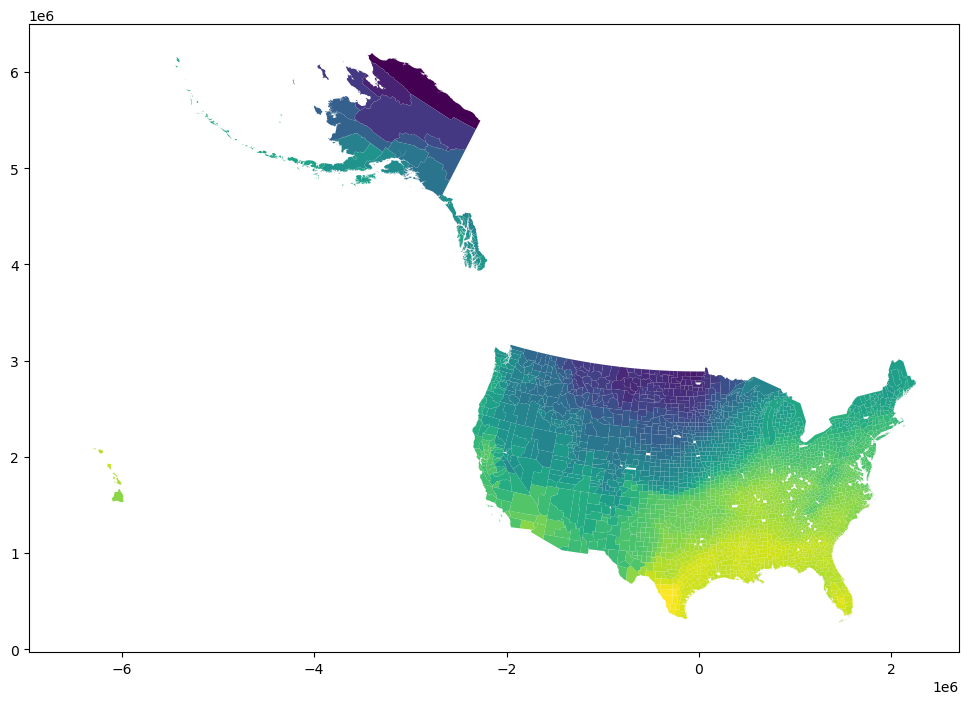

In [60]:
fig, ax = plt.subplots(figsize = (12,10))

gdf = gdf_us_states_counties.to_crs('epsg:5070')
gdf.plot(column="zs_mean", ax=ax)

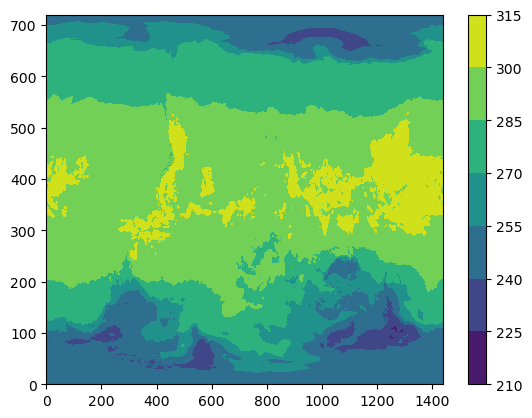

In [21]:
plt.contourf(cds_dataset['t2m'][0,:,:])
plt.colorbar()